In [1]:
import math
import numpy as np
import pandas as pd
import pints
import matplotlib.pyplot as plt
import os
plt.rcParams.update({'font.size': 24})
from Newton_model_numba import wrappedNewton, newtonRaphsonFT

In [2]:
# specifing data location and folder for outputs

data_name = '9 150_1_cv_current_reduced_2'
file_name = data_name + '.txt'
folder = os.path.join('Data', 'processed')
folder = os.path.join(folder, '220415')
folder = os.path.join(folder, 'ph 2m nacl 25oC')
folder = os.path.join(folder, 'ac')
data_file = os.path.join(folder, file_name)

# creating file for output
fitting_technique = 'harmonic '
output_file_name = fitting_technique + 'fitting_for_faradaic_data'
output_file_name = output_file_name + '.txt'
folder = os.path.join(folder, 'faradaic_fitting')
folder = os.path.join(folder, 'harmonics4-12')
f= open(os.path.join( folder, output_file_name),"w")

# opening data
experimental_data = pd.read_csv(data_file, sep='\t')

exp_times = np.asarray(experimental_data.time)
exp_current = np.asarray(experimental_data.current)

In [3]:
# # delacring know model paramters
# inital_current = exp_current[0]
# freq = 8.95931721948
# startPotential= -0.15
# revPotential = -0.75
# rateOfPotentialChange = -22.35e-3
# deltaepislon = 150E-3
# uncomp_resis = 27.160770551
# electrode_area = 0.03
# electode_coverage = 6.5e-12

# know paramteres for 9_1b_cv_current_reduced_2
inital_current = exp_current[0]
freq = 8.977950e+00
startPotential= -300.0E-3
revPotential = -900.0E-3
rateOfPotentialChange = -22.35174e-3
uncomp_resis = 8.88238377990564061e+01

deltaepislon = 150.0E-3
electrode_area = 0.03
electode_coverage = 6.5e-12

# delacring capactiance parameters
# (gamma0, gamma1, gamma2, gamma3, omega)
#cap_params = (1.87851979866104002e-04,  1.55973008249306192e-04,  3.98991608216834985e-04,  2.11324969277902771e-04, -6.47033375127571162e+01)
cap_params = (1.91275996128693611e-04, -2.05886937234544707e-04, -3.30120556836988347e-04, -2.28277851460101844e-04, -6.47026581947250747e+01)

In [4]:
measurements = exp_current.shape[0]
print('measurements: ', measurements)
if measurements%2 !=0:
    print('*'*30+'\nerror must have evennumber of measurments\n'+'*'*40)

# declaring model to obtain non dimensinalise constant
trial = newtonRaphsonFT(timeStepSize=exp_times[1], inital_current=inital_current, freq=freq, startPotential= startPotential, revPotential = revPotential,
                        rateOfPotentialChange = rateOfPotentialChange, numberOfMeasurements = measurements, deltaepislon=deltaepislon,
                        uncomp_resis=uncomp_resis, electrode_area=electrode_area, electode_coverage=electode_coverage)

# non-diming experimental data
exp_current_dimless = exp_current/trial.I0

# model for optimsation
model = wrappedNewton(times = exp_times, inital_current=inital_current, freq=freq, startPotential= startPotential, revPotential = revPotential,
                        rateOfPotentialChange = rateOfPotentialChange, deltaepislon=deltaepislon,
                        uncomp_resis=uncomp_resis, electrode_area=electrode_area, electode_coverage=electode_coverage,
                        initaldiscard = 0.035, enddiscard = 0.885, cap_params=cap_params)

real_parameters = model.suggested_parameter()
parameter_order = ['kappa0_1', 'kappa0_2', 'epsilon0_1', 'epsilon0_2', 'mew', 'zeta']
real_parameters = np.asarray(real_parameters)
f.write("experimental data: " + data_file + "\r\n")
print('experimental data: ',data_file)

measurements:  80658
experimental data:  Data/processed/220415/ph9 2m nacl 25oC/ac/9 150_1_cv_current_reduced_2.txt


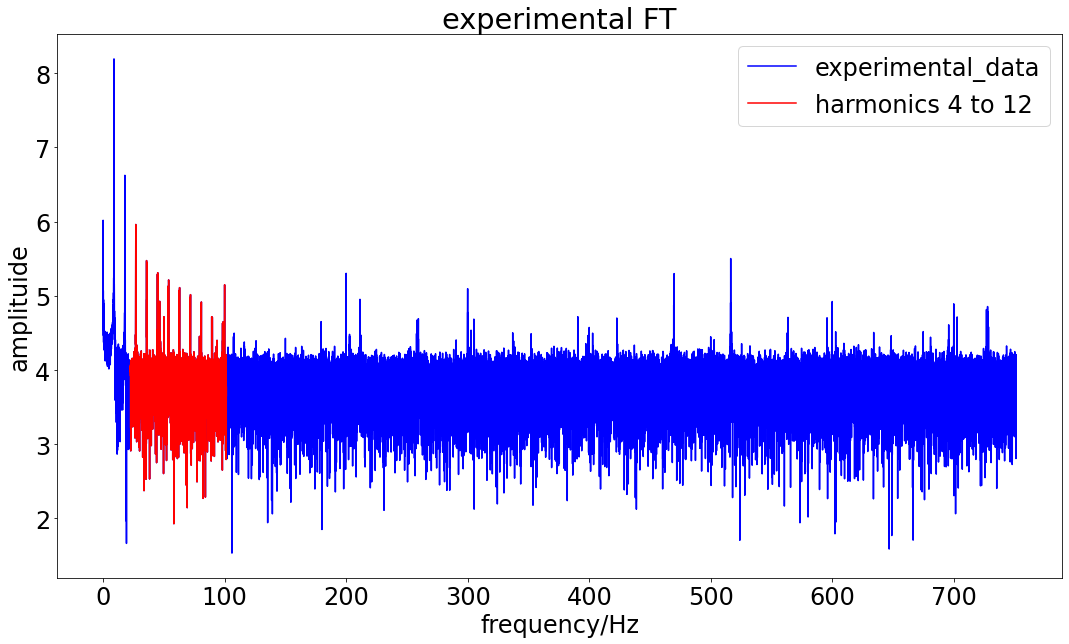

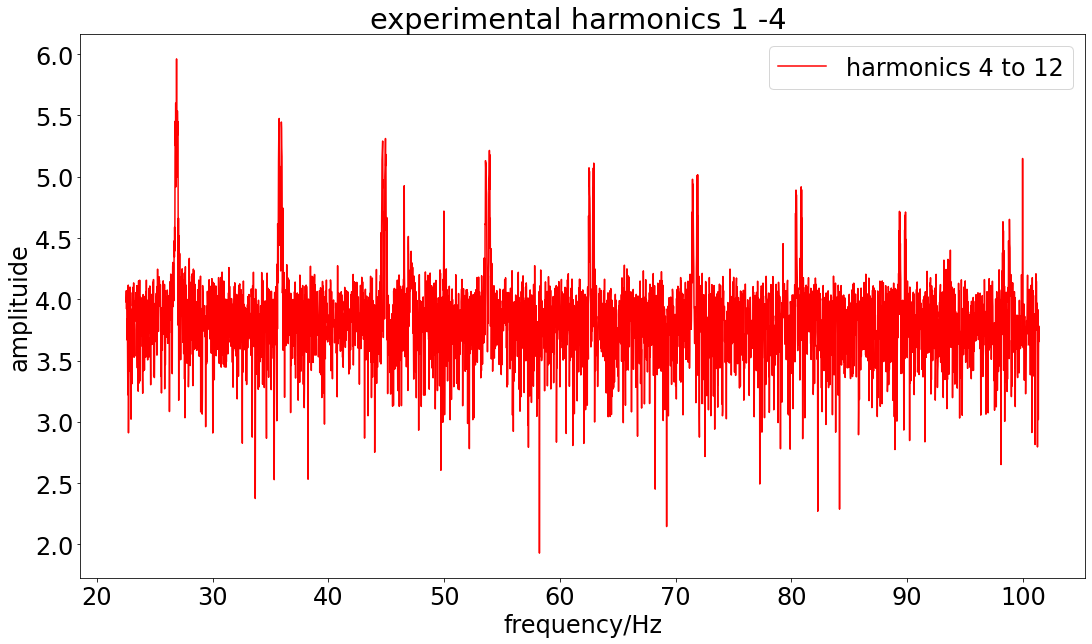

In [5]:
# checking loaction of harmonics 1-4
half_of_measuremnts = int(measurements/2)

# full FT and frequencies
full_sim = np.fft.fft(exp_current_dimless)
half_full_sim = full_sim[:half_of_measuremnts]

freq_org = np.fft.fftfreq(exp_times.shape[-1], d= exp_times[1])
freq_org=freq_org[:half_of_measuremnts]

# regional FT and Frequency

freq = model.frequencies_for_harmonics_4_to_12(exp_times)

harmonics1To4 = model.FT_and_reduce_to_harmonics_4_to_12(exp_current_dimless)

xaxislabel = "frequency/Hz" # "potential/V"
plt.figure(figsize=(18,10))
plt.title("experimental FT")
plt.ylabel("amplituide")
plt.xlabel(xaxislabel)
plt.plot(freq_org, np.log10(half_full_sim),'b', label='experimental_data')
plt.plot(freq, np.log10(harmonics1To4),'r', label='harmonics 4 to 12')
plt.legend(loc='best')
plt.show()

xaxislabel = "frequency/Hz" # "potential/V"
plt.figure(figsize=(18,10))
plt.title("experimental harmonics 1 -4 ")
plt.ylabel("amplituide")
plt.xlabel(xaxislabel)
plt.plot(freq, np.log10(harmonics1To4),'r', label='harmonics 4 to 12')
plt.legend(loc='best')
plt.show()

In [6]:
class ComplexRootMeanSquaredError_harmonics(pints.ProblemErrorMeasure):
    def __init__(self, problem, model, Hz_interval, times):
        super(ComplexRootMeanSquaredError_harmonics, self).__init__(problem)

        if not isinstance(problem, pints.SingleOutputProblem):
            raise ValueError(
                'This measure is only defined for single output problems.')
        
        self.FT_values = model.FT_and_reduce_to_harmonics_4_to_12(self._values)
        self.harmonic_spacing = model.harmonic_spacing(self._values, times)
        print('harmonic_spacing (480): ', self.harmonic_spacing)
        self.mid_point_index = np.argmax(self.FT_values)
        print('mid_point_index (303): ', self.mid_point_index)
        self.index_window = int(np.round(model.index_distance_covering(Hz_interval, times)))
        print('index_window (80): ', self.index_window)
        self.data_dims = self.FT_values.shape[0]

        # np.absolute takes the element wise absoulte value of real numbers, 
        # and the element-wise modules/eulcdiean norm/ absoulte value of comlex numbers
        # i.e for: z = a +bi
        # |z| = sqrt(a^2+b^2)

    def __call__(self, x):

        simulation = self._problem.evaluate(x)
        reduced_FT_sim = model.FT_and_reduce_to_harmonics_4_to_12(simulation)

        low = int(self.mid_point_index - self.index_window)
        high = int(self.mid_point_index+ self.index_window + 1)

        total_complex_diff = 0.0   
        while high <= self.data_dims:
            sim_harmonic = reduced_FT_sim[low:high]
            exp_harmonic = self.FT_values[low:high]

            kaiser_window = np.kaiser(exp_harmonic.shape[0], 0)

            complex_diff = sim_harmonic - exp_harmonic

            windowed = np.multiply(kaiser_window,complex_diff)

            total_complex_diff = total_complex_diff + windowed

            # increasing indexing
            high = high + self.harmonic_spacing 
            low = low + self.harmonic_spacing 

        # complex_diff = reduced_FT_sim - self.FT_values

        # magnatuide = np.absolute(complex_diff)

        magnatuide = np.absolute(total_complex_diff)

        squares = np.square(magnatuide)

        sumed = np.sum(squares)

        return np.sqrt(sumed)

arg max give :  480
spacing bewteen harmonics is therefore :  479
real arg max give :  480
real_spacing bewteen harmonics is therefore :  479
absolute arg max give :  481
absolute spacing bewteen harmonics is therefore :  480
imag arg max give :  480
imag_spacing bewteen harmonics is therefore :  480


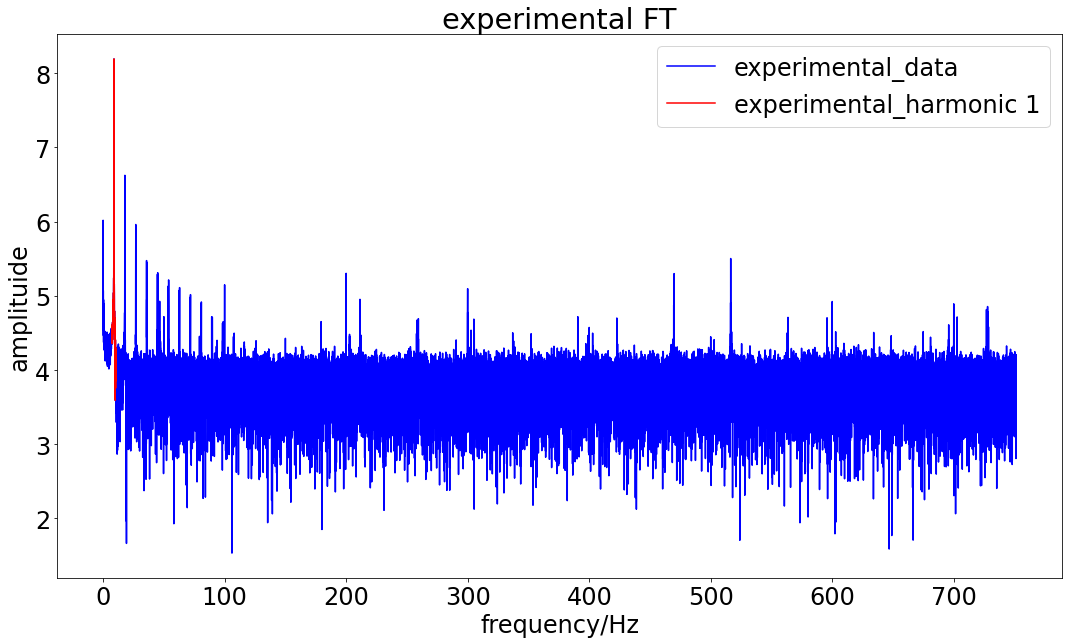

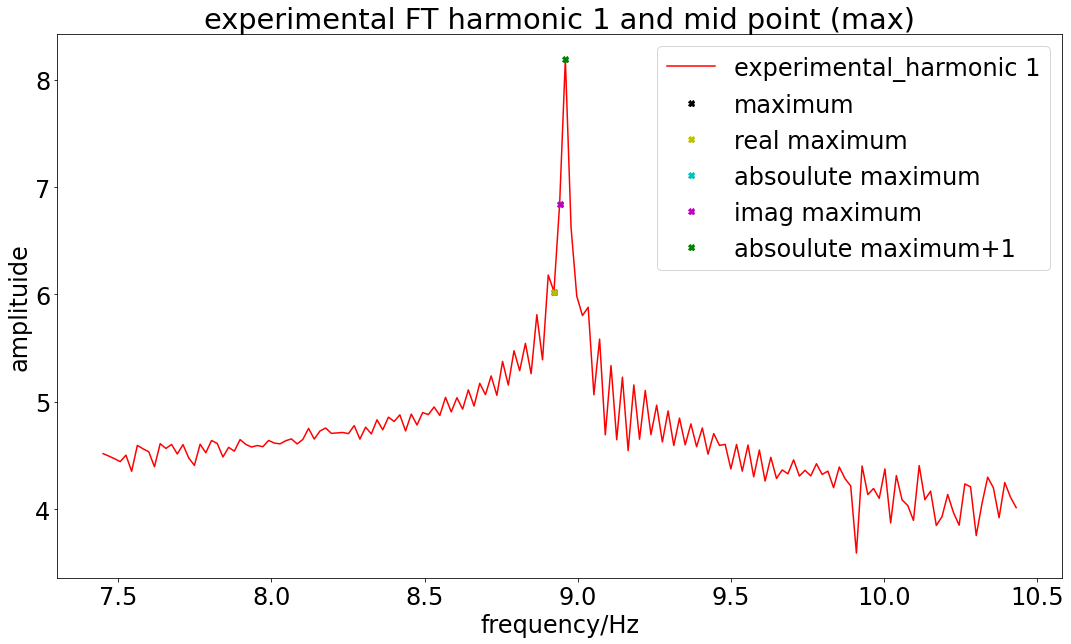

harmonic_spacing (480):  481
mid_point_index (303):  234
index_window (80):  32
Score at papers solution: 3482633.676974899
Score at found solution: 2866885.772175419


In [7]:

problem = pints.SingleOutputProblem(model, exp_times, exp_current_dimless)

score = ComplexRootMeanSquaredError_harmonics(problem, model, Hz_interval=0.6, times=exp_times)

# boundary conditions
# kappa0_1, kappa0_2, epsilon0_1, epsilon0_2, mew, zeta, sigma
#[3400.0, 3400.0, -0.437459534627, -0.46045114238, -0.031244092599793216, 1.0]
e_min = model.startPotential + 0.2*(model.revPotential - model.startPotential)
e_max = model.startPotential + 0.8*(model.revPotential - model.startPotential)
# f.write("e_min: %e\r\n" % e_min)
# f.write("e_max: %e\r\n" % e_max)
# print('e_min: ',e_min)
# print('e_max: ',e_max)
lower_bounds = np.asarray([0.0, 0.0, e_max, e_max, -0.314, 0.0])#, 0.1])
upper_bounds = np.asarray([4000.0, 4000.0, e_min, e_min, 0.314, 10])#, 4.5])

boundaries = pints.RectangularBoundaries(lower_bounds, upper_bounds)
print("Score at papers solution:", score(real_parameters))
found_params = [5.06670907862494602e+00,  9.89015401127633936e+02,
                -2.99712963556115097e-01, -4.46238055110197540e-01, 
                 1.90280568779692127e-02,  1.31115829339899492e+00]
print("Score at found solution:", score(found_params))
# Score at papers solution: 877785.9197391798
# Score at found solution: 1006276.6135752603

# second method: using Hz_interval = 0.6 and beta = 0 for window
# Score at papers solution: 604530.1416181454
# Score at found solution: 909797.3925993853

**********cacluating harmonic spacing**********
arg max give :  480
spacing bewteen harmonics is therefore :  479
real arg max give :  480
real_spacing bewteen harmonics is therefore :  479
absolute arg max give :  481
absolute spacing bewteen harmonics is therefore :  480
imag arg max give :  480
imag_spacing bewteen harmonics is therefore :  480


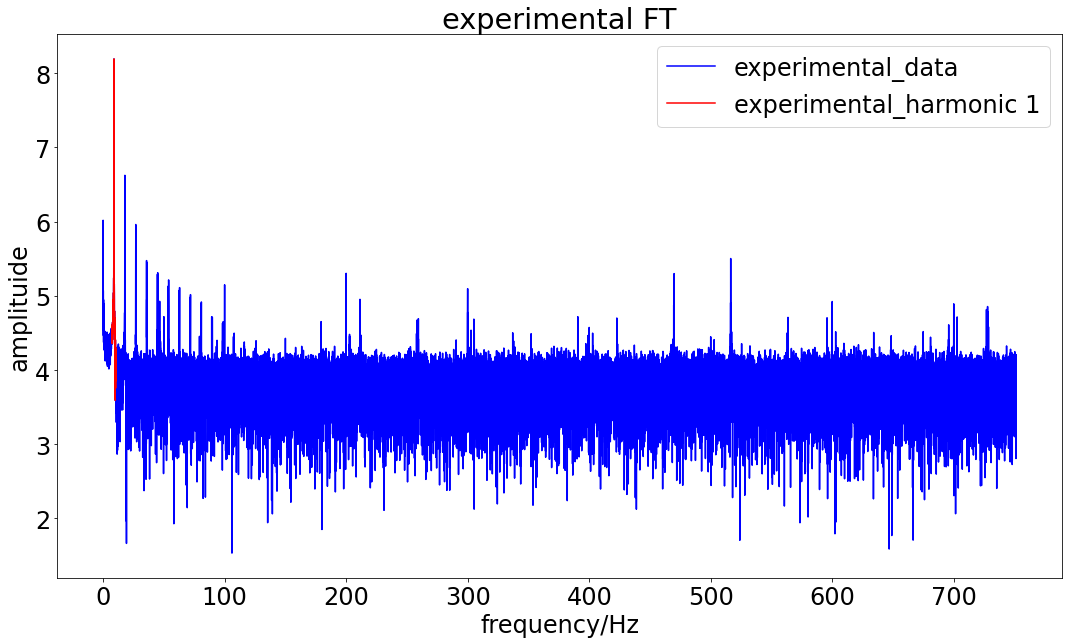

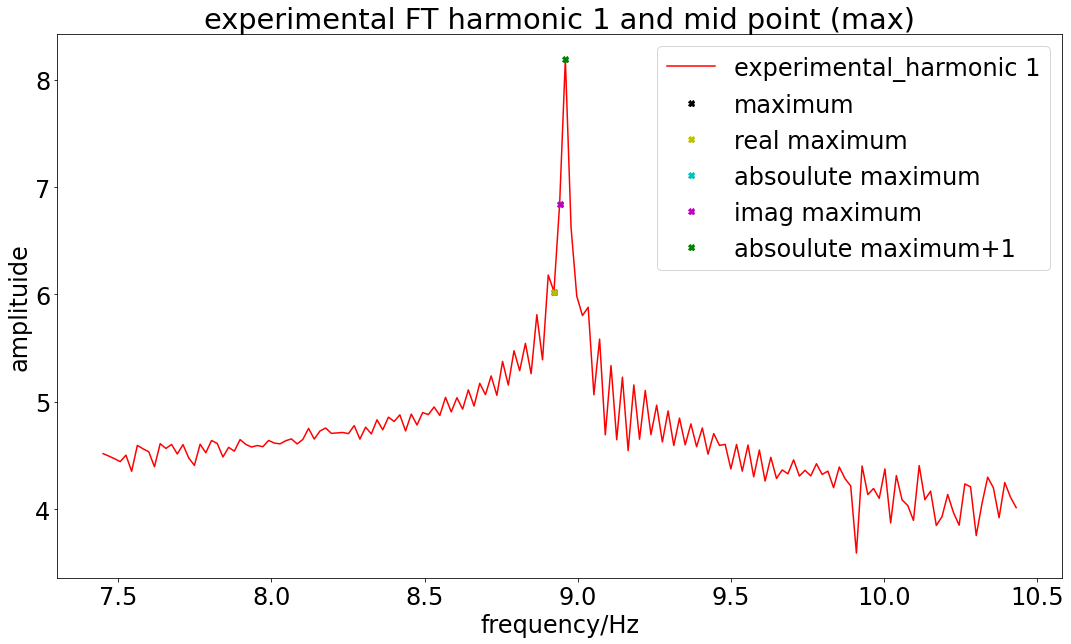

Spacing between harmonics:  481

**********cacluating location of 4th harmonic**********
mid point index of 4th harmonic:  234

**********index distance of 0.6Hz**********
index window covering 0.6Hz:  32.21157888
int index window covering 0.6Hz:  32.0
sim_plot.shape: (65,)
mid_upper_sim_plot.shape: (33,)
lower_sim_plot.shape: (32,)


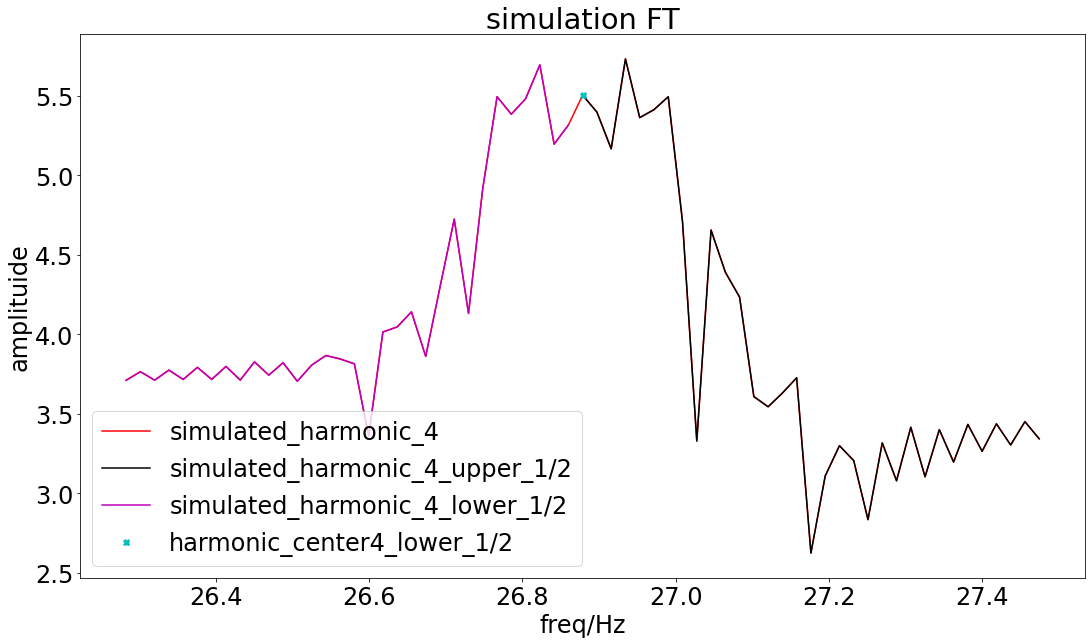

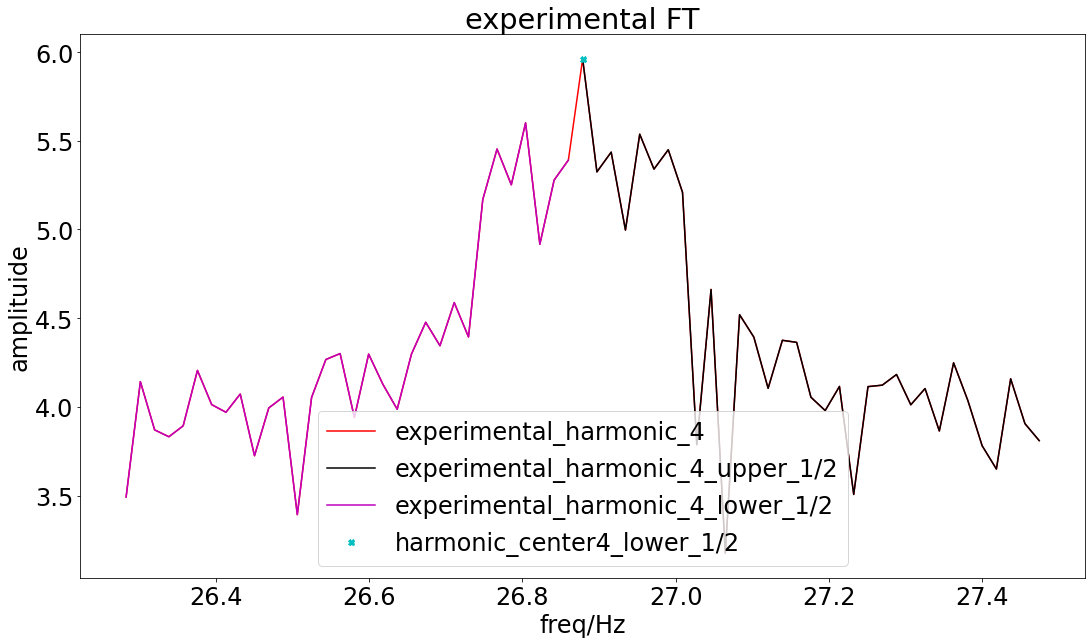

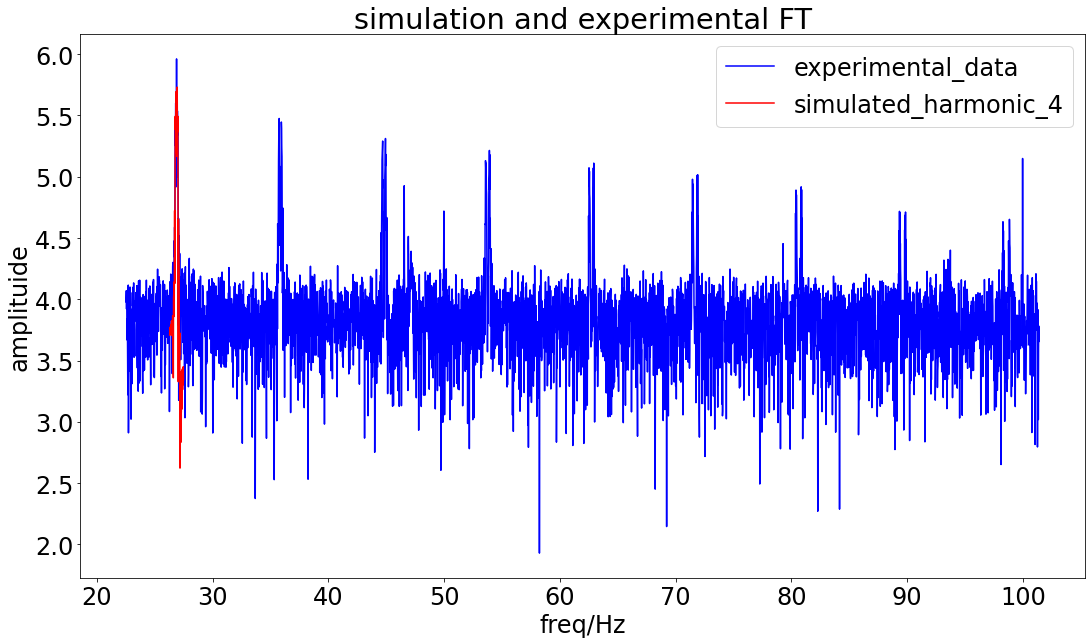

sim_plot.shape: (65,)
mid_upper_sim_plot.shape: (33,)
lower_sim_plot.shape: (32,)


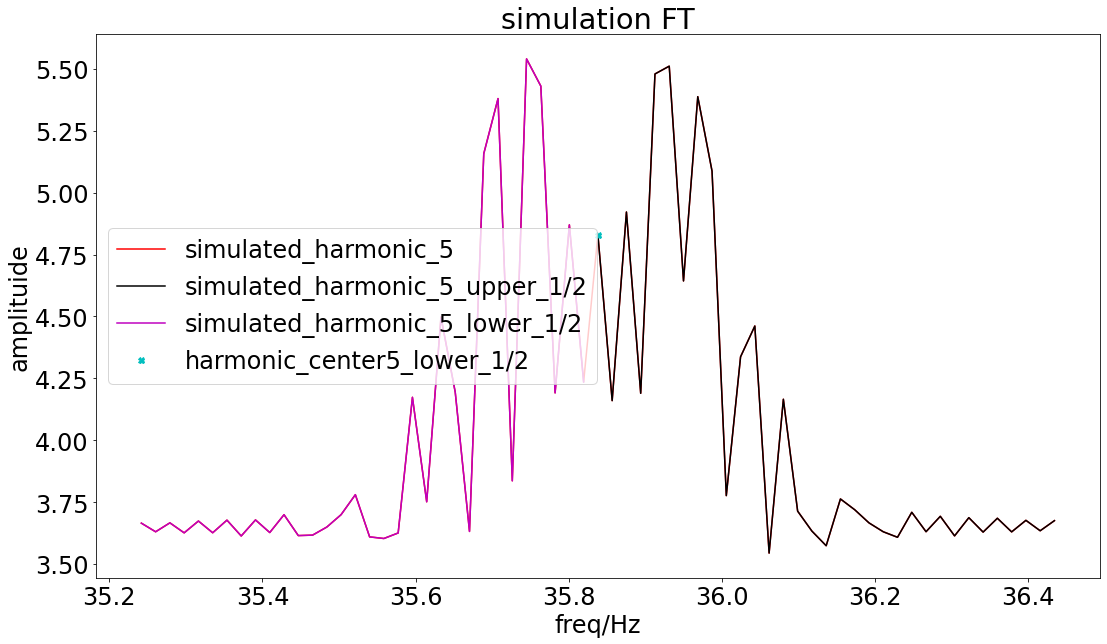

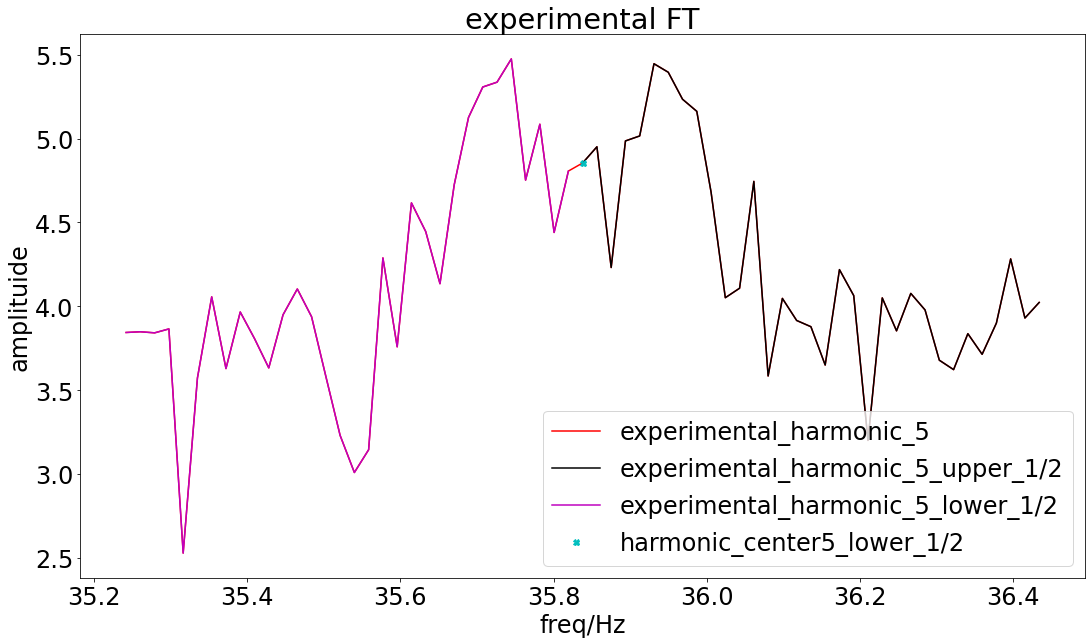

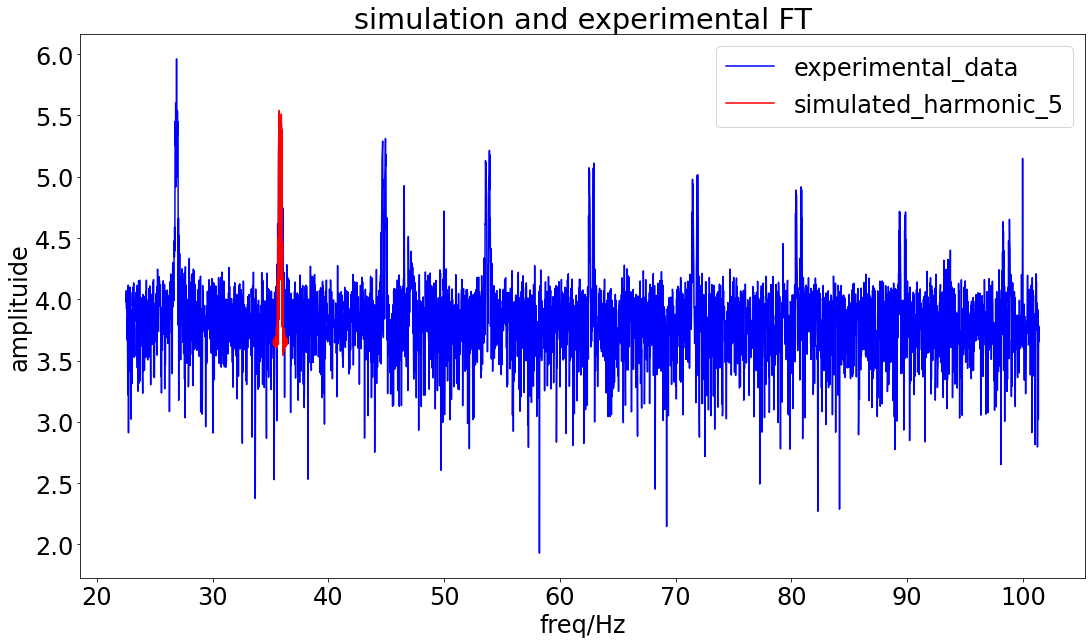

sim_plot.shape: (65,)
mid_upper_sim_plot.shape: (33,)
lower_sim_plot.shape: (32,)


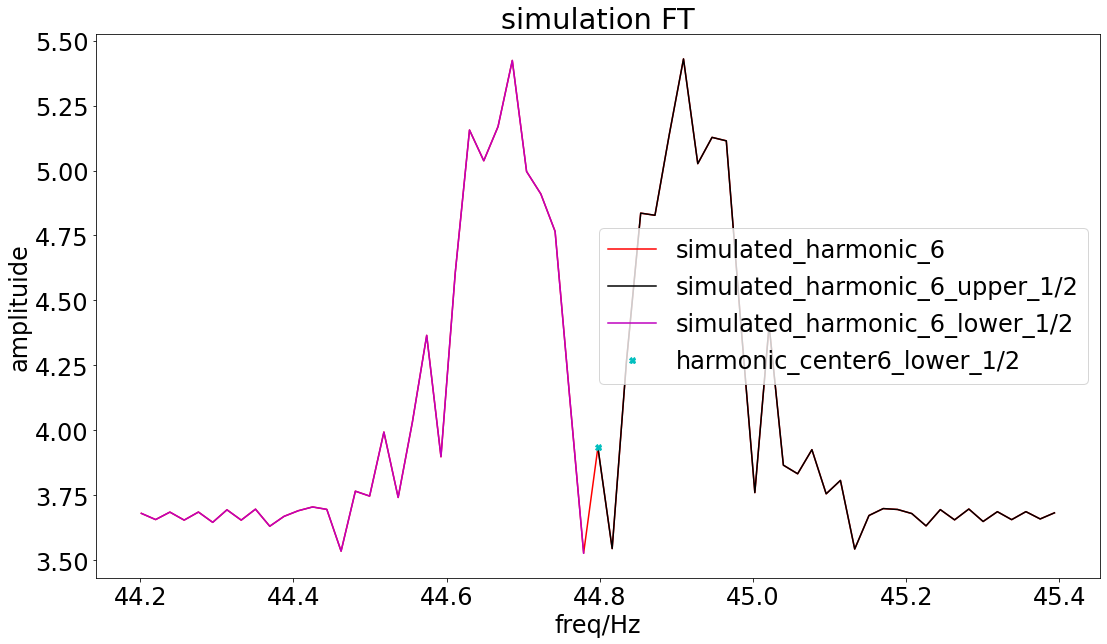

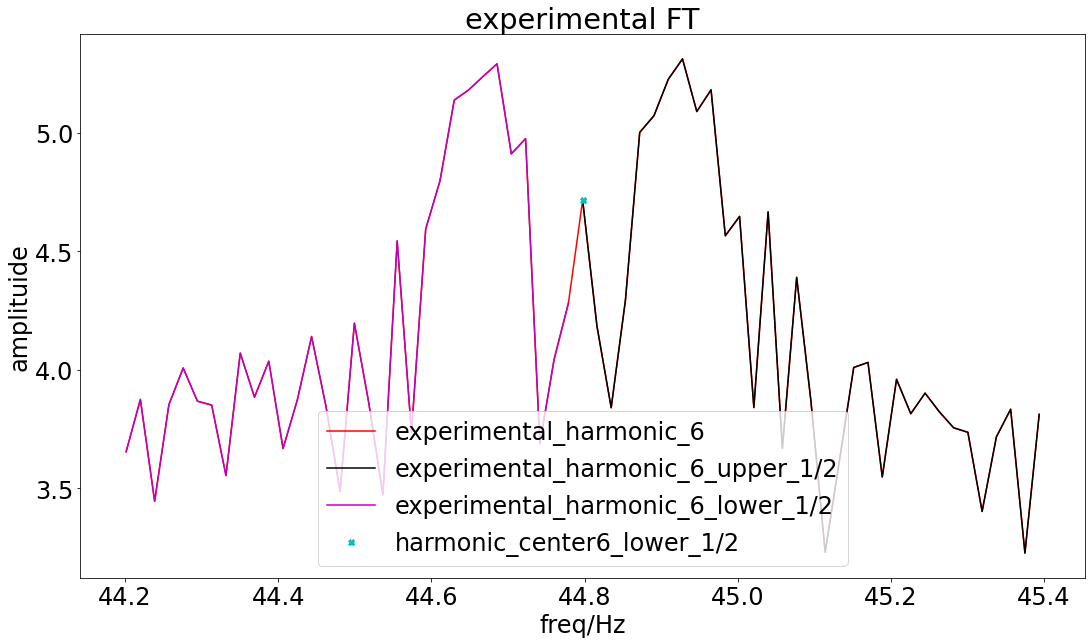

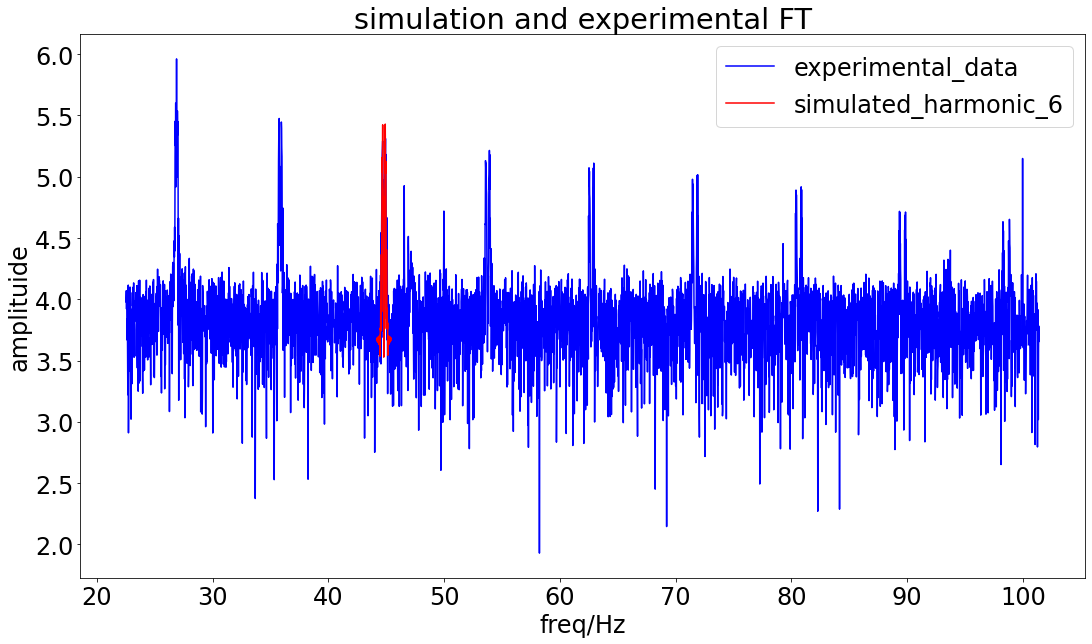

sim_plot.shape: (65,)
mid_upper_sim_plot.shape: (33,)
lower_sim_plot.shape: (32,)


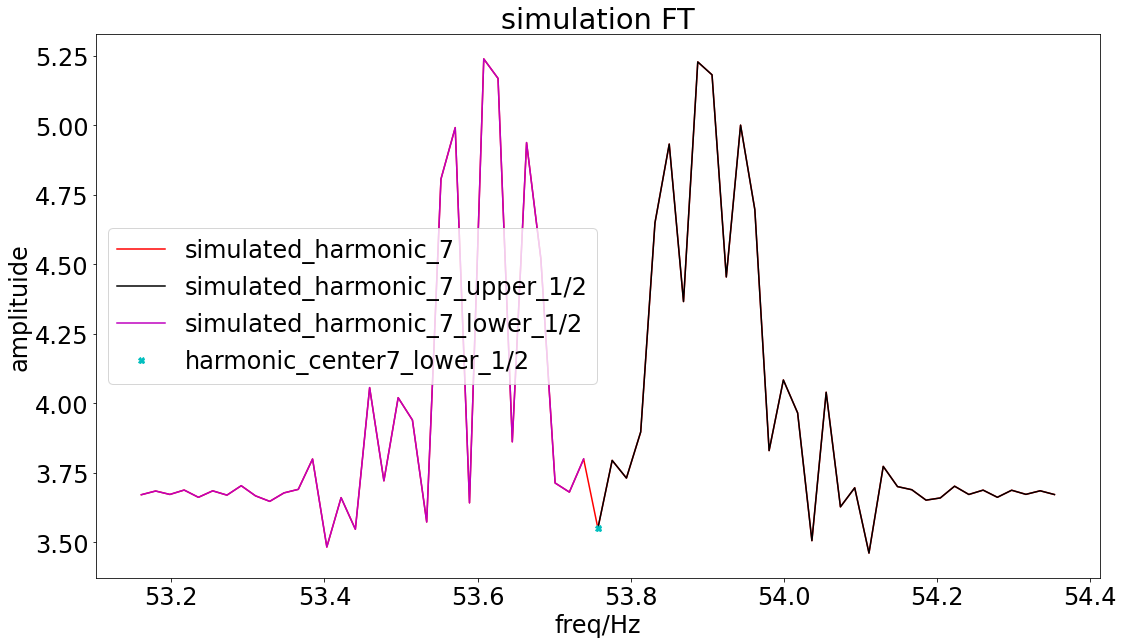

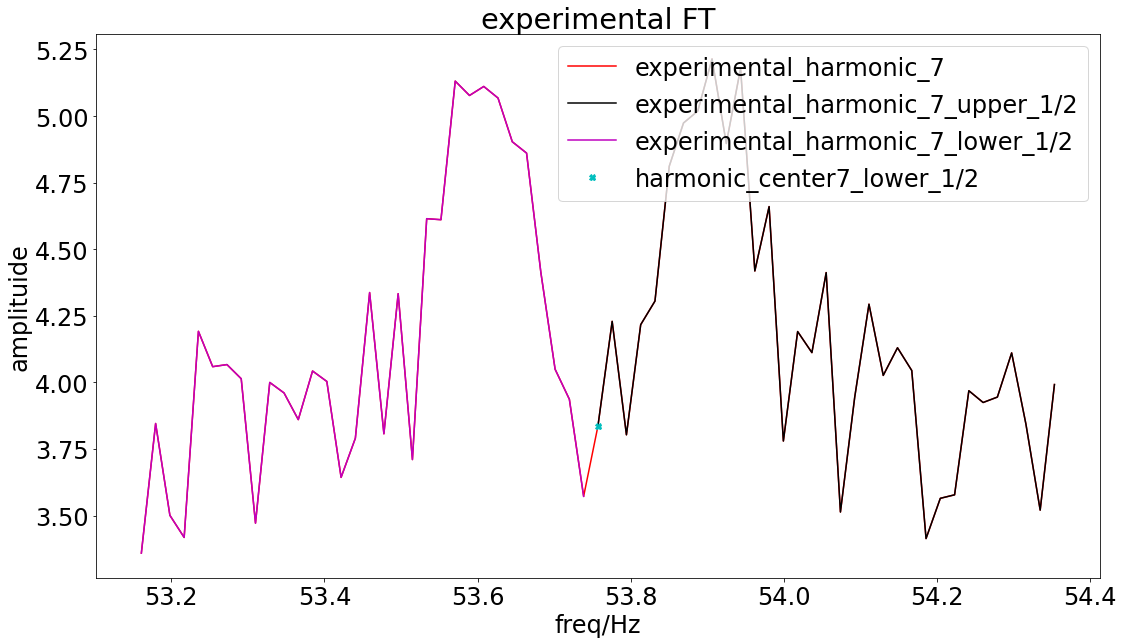

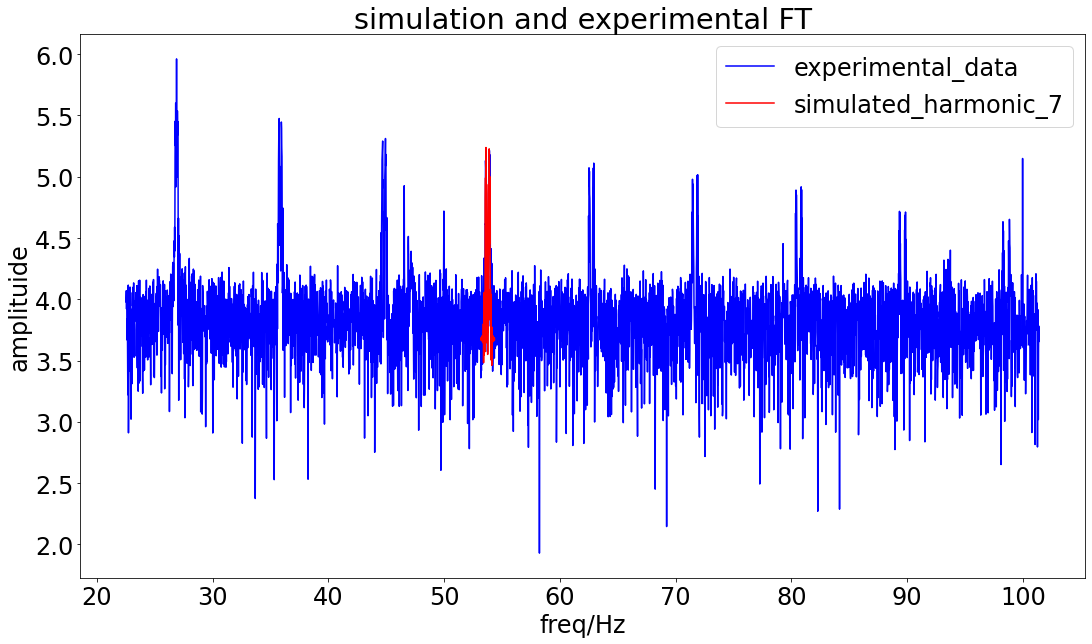

sim_plot.shape: (65,)
mid_upper_sim_plot.shape: (33,)
lower_sim_plot.shape: (32,)


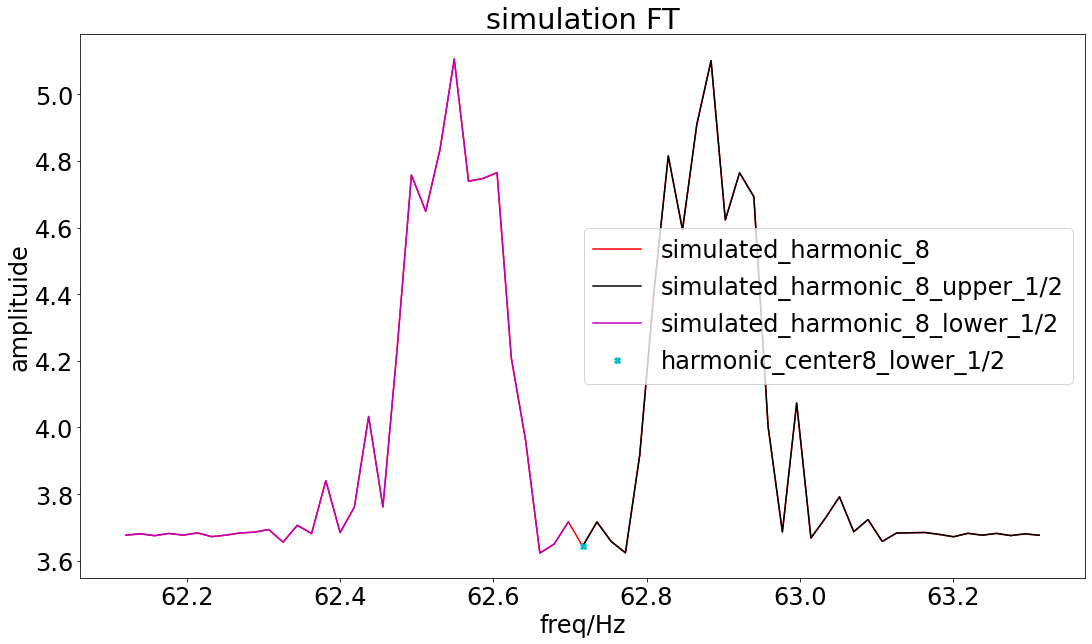

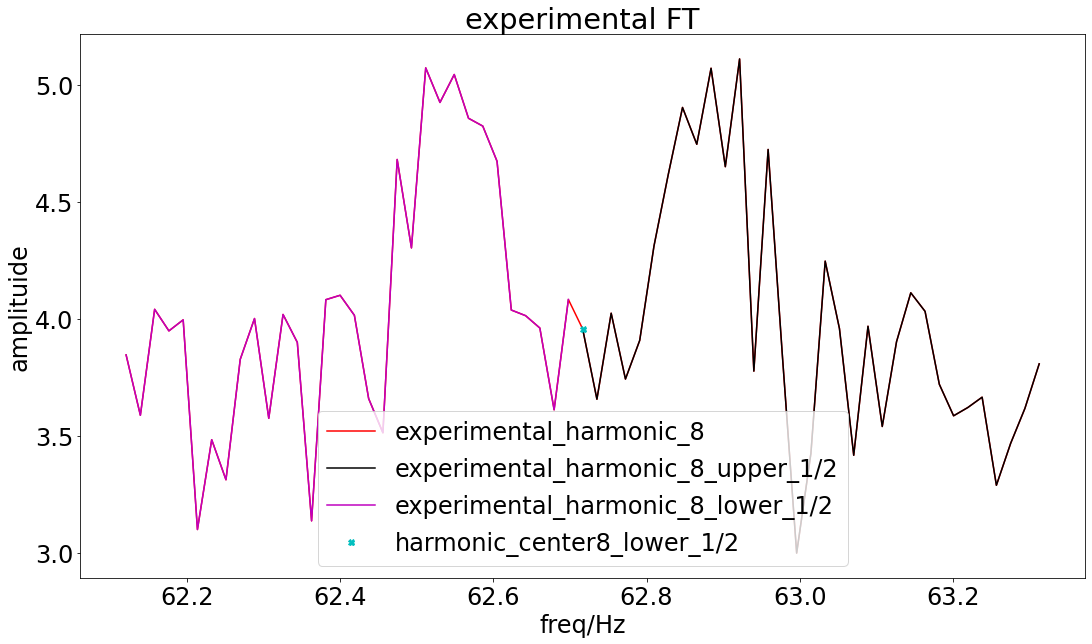

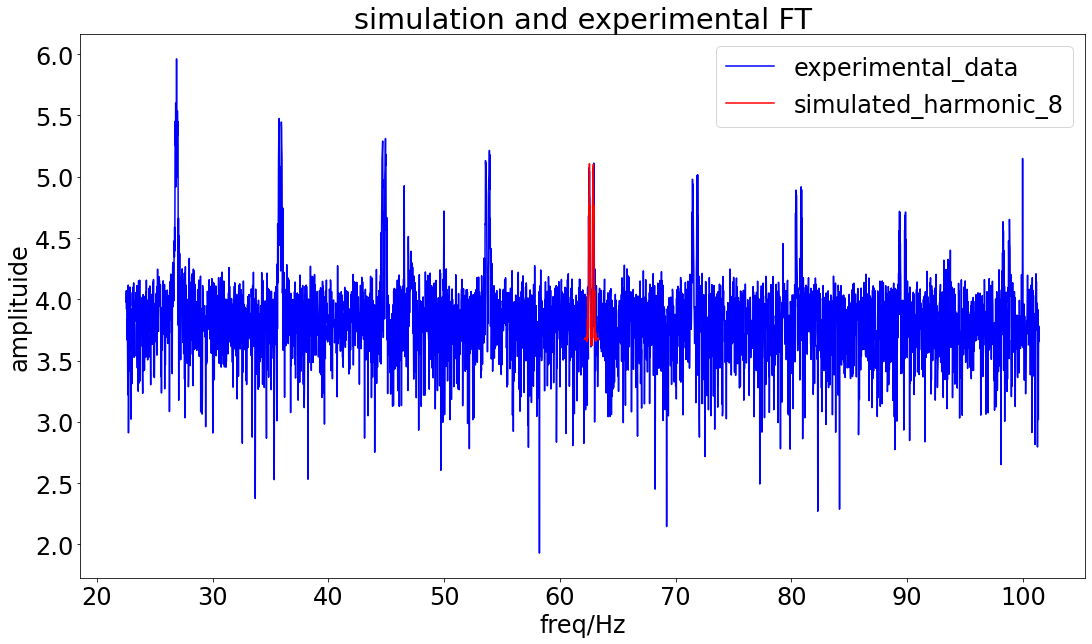

sim_plot.shape: (65,)
mid_upper_sim_plot.shape: (33,)
lower_sim_plot.shape: (32,)
sim_plot.shape: (65,)
mid_upper_sim_plot.shape: (33,)
lower_sim_plot.shape: (32,)


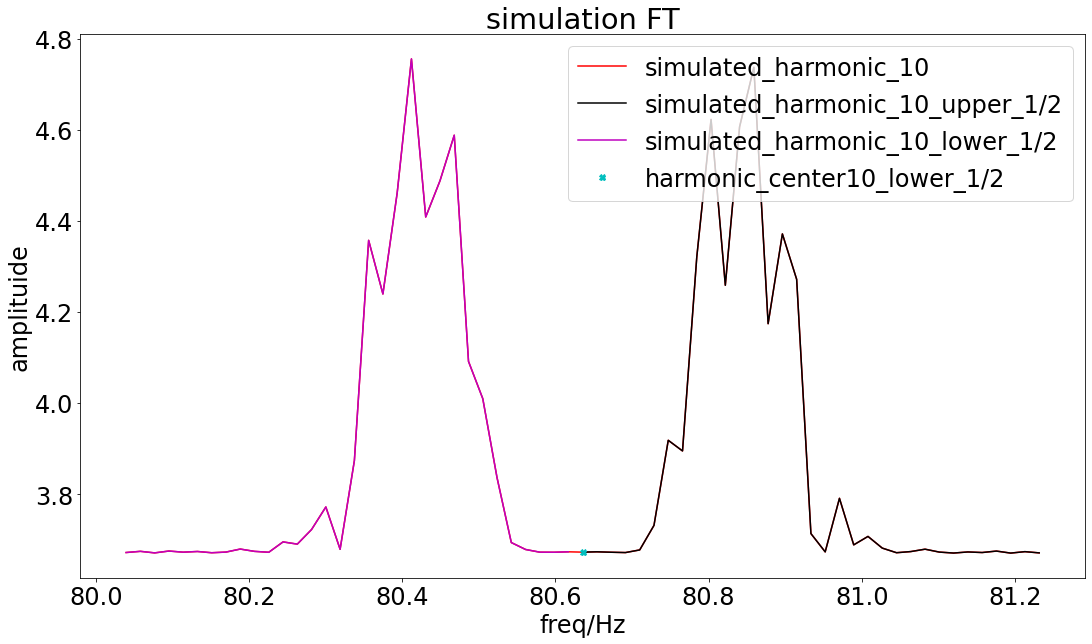

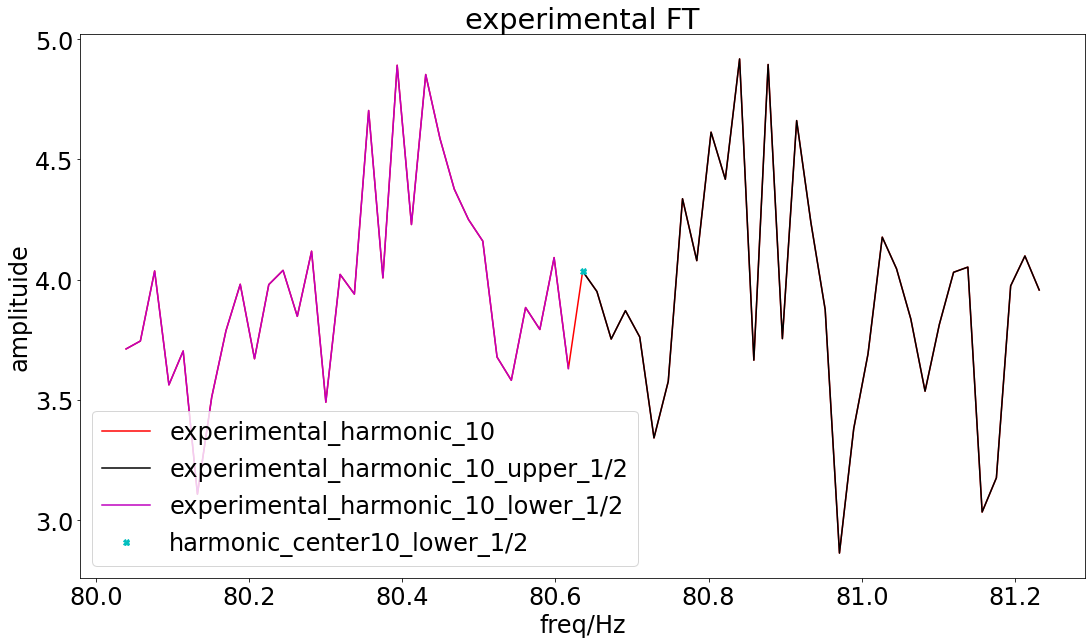

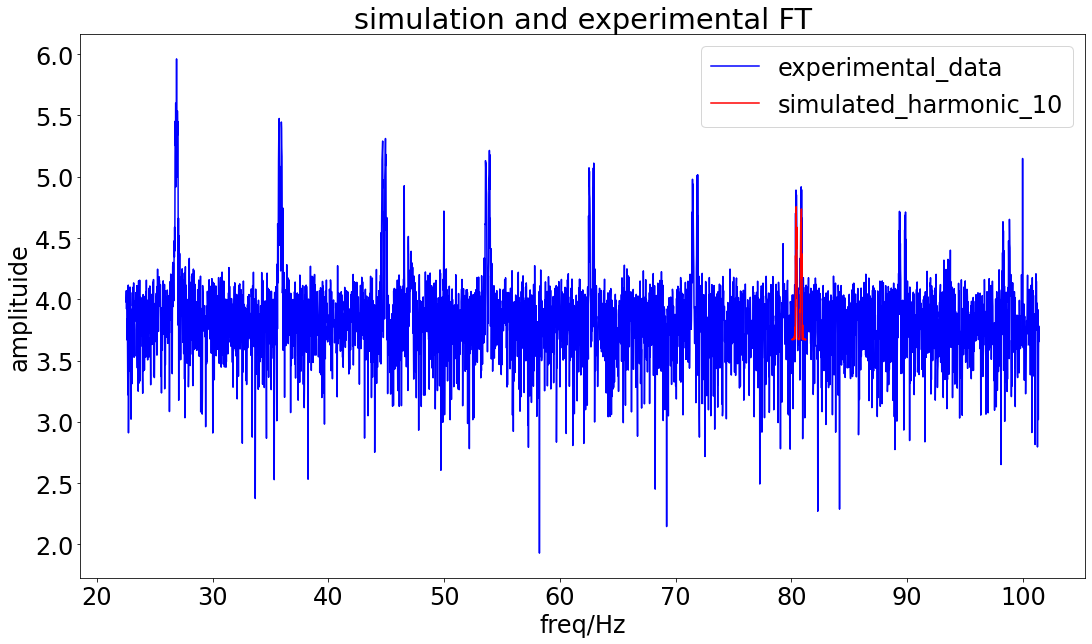

sim_plot.shape: (65,)
mid_upper_sim_plot.shape: (33,)
lower_sim_plot.shape: (32,)
sim_plot.shape: (65,)
mid_upper_sim_plot.shape: (33,)
lower_sim_plot.shape: (32,)


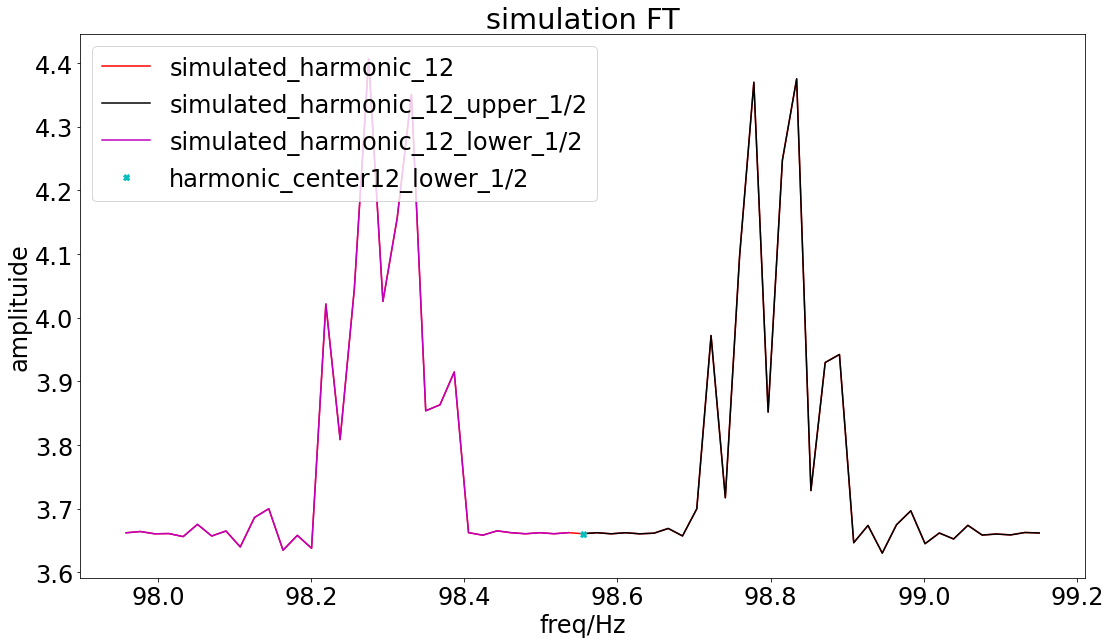

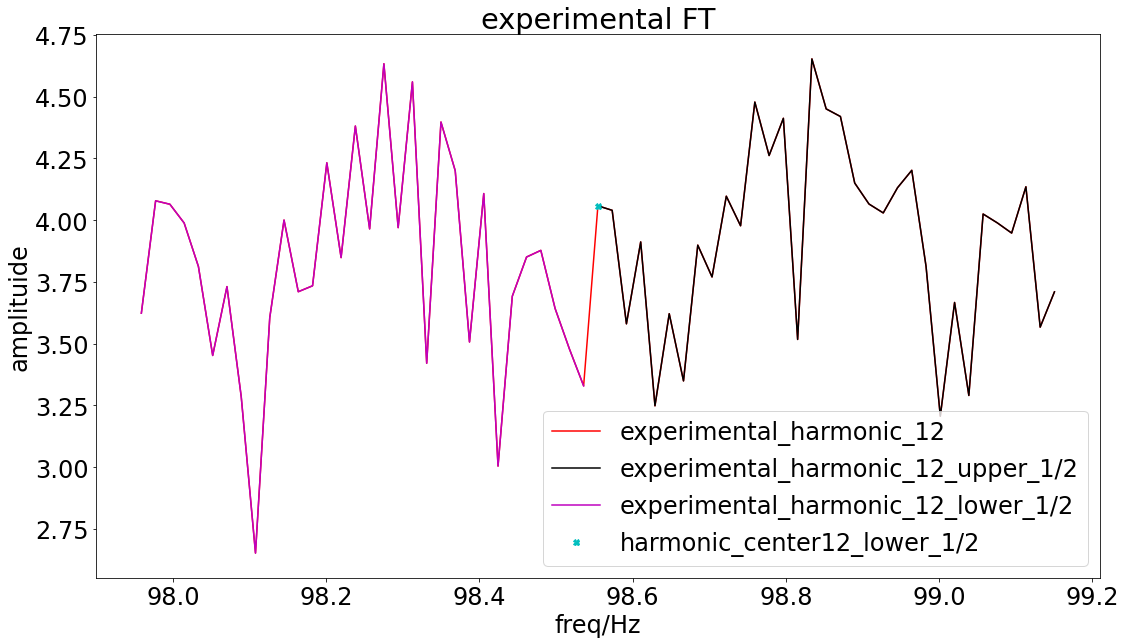

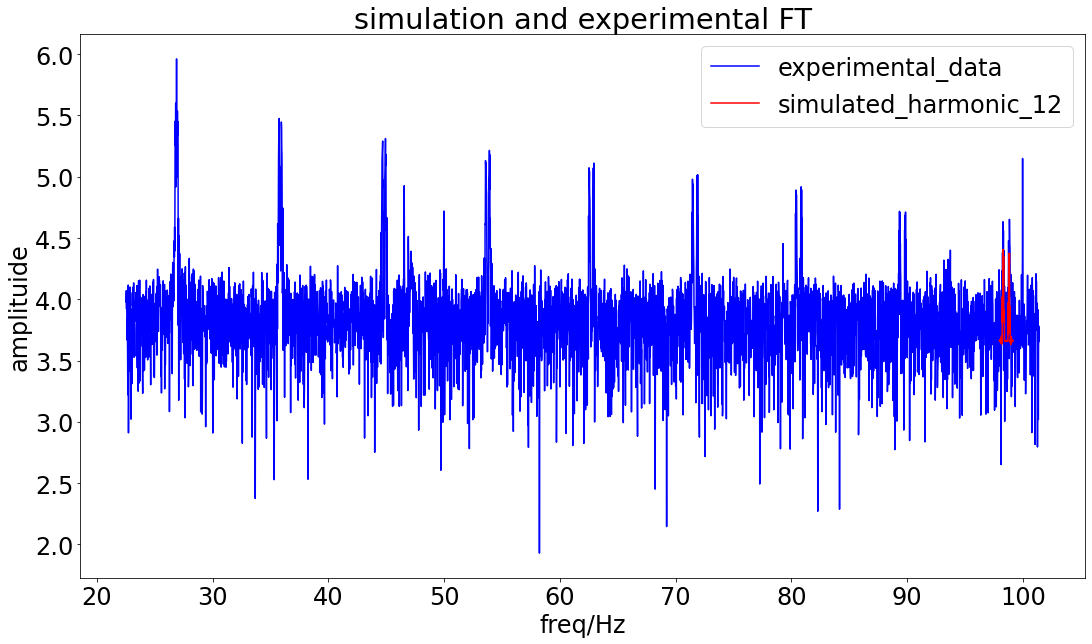

In [8]:
# checking harmonics are in the right place

print_all_harmonics = False
print_these_harmonics = [4,5,6,7,8,10,12,13]
model.ploting_harmonic(experimental_data = exp_current_dimless, times = exp_times, parameter_for_sim = real_parameters, Hz_interval = 0.60, print_all_harmonics= print_all_harmonics, print_these_harmonics = print_these_harmonics, check_FT_harmonic_locations = True, print_harmonics = False)


In [9]:
total_runs = 20
dims = real_parameters.shape
print('dims: ', dims)
print('dims[0]: ', dims[0])
params_matrix = np.zeros((total_runs, dims[0]))
for run in range(total_runs):
        
    if run > 0:
        f = open(os.path.join( folder, output_file_name),"a")

    f.write("\r\n\r\n" + 40*"*" + " Run: %d " % run + 40*"*" + "\r\n\r\n")
    print('\n\n' + 40*"*" + ' Run: ', run, ' ' + 40*"*" + '\n\n')
    accuracy = (2 + run)
    # f.write("Threshold for stopping: %e\r\n\r\n" % pow(10,-accuracy))
    # print('Threshold for stopping: ', pow(10,-accuracy))

    ranges = upper_bounds - lower_bounds 

    starting_points = np.copy(lower_bounds)
    for i in range(len(ranges)):
        starting_points[i] += ranges[i] * np.random.uniform(low = 0.001, high = 0.999)
    
    print('lower_bounds: ', lower_bounds)
    print('upper_bounds: ', upper_bounds)

    if run == 0:
        starting_points = [3.99999999974716229e+03,  7.99009579294218042e+02,
                           -3.56170503302131569e-01, -3.02495382529122891e-01,
                           5.65224245813011339e-02,  6.51803052065346611e-01]
    # print('random starting points: ', starting_points)

    f.write("lower_bounds: ")
    for i in lower_bounds:
        f.write("%e, " % i)
    f.write("\r\nupper_bounds: ")
    for i in upper_bounds:
        f.write("%e, " % i)
    f.write("\r\nRandom starting_points: ")
    for i in starting_points:
        f.write("%e, " % i)
    f.write("\r\n")

    # transformation
    transform = pints.RectangularBoundariesTransformation(boundaries)

    # optimising boundaries=boundaries,
    opt = pints.OptimisationController(
        score,
        x0=starting_points,
        method=pints.CMAES,
        transform = transform)

        
    #opt.set_max_unchanged_iterations(iterations=50, threshold=pow(10,-accuracy))
    #opt.set_max_unchanged_iterations(iterations=100)
    opt.set_parallel(parallel=True)
    #opt.set_max_iterations(iterations=10)
    opt.set_log_interval(iters=10, warm_up=3)
    #opt.set_threshold(threshold=-??????)
    
    found_parameters, found_value =  opt.run()
        #CMAES, PSO, SNES, XNES
    # output results

    print('random starting points: ', starting_points)

    f.write("Found solution: ")
    for k, x in enumerate(found_parameters):
        f.write(pints.strfloat(x) +", ")

    print('         Found solution:          True parameters:' )
    name = 0
    for k, x in enumerate(found_parameters):
        print( pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]) + '  :' + parameter_order[name])
        name = name + 1

    print('lower_bounds: ', lower_bounds)
    print('upper_bounds: ', upper_bounds)

    f.write("\r\n\r\nFound solution:          True parameters:\r\n")
    name = 0
    for k, x in enumerate(found_parameters):
        f.write(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k])+ '  :' + parameter_order[name]+ '\r\n')
        name = name + 1

    params_matrix[run, :] = found_parameters

    # plotting current for found parameters over the experimentally data

    xaxis = exp_times #model.potentialRange
    xaxislabel = "time/s" # "potential/V"
    solution = model.simulate(found_parameters, exp_times)


    plt.figure(figsize=(18,10))
    plt.title("optimised and experimental values")
    plt.ylabel("Fourier transformed current/dimless")
    plt.xlabel(xaxislabel)
    plt.plot(xaxis, exp_current_dimless,'r', label='experiment')
    plt.plot(xaxis ,solution,'b', label='optimised_'+str(found_parameters[0])+'_'+str(found_parameters[1]))
    plt.legend(loc='best')
    plt.savefig(os.path.join( folder, 'experiment against optimised with potential run '+str(run)+'.png'))
    #plt.show()
    plt.close()

    plt.figure(figsize=(18,10))
    plt.title("optimised and experimental values")
    plt.ylabel("Fourier transformed current/dimless")
    plt.xlabel(xaxislabel)
    plt.plot(xaxis ,solution,'b', label='optimised_'+str(found_parameters[0])+'_'+str(found_parameters[1]))
    plt.plot(xaxis,exp_current_dimless,'r', label='experiment')
    plt.legend(loc='best')
    plt.savefig(os.path.join( folder, 'optimised against experiment with potential run '+str(run)+'.png'))
    #plt.show()
    plt.close()

    print("Score at true solution:", score(real_parameters))
    print("Score at found solution:", score(found_parameters))
    f.write("\r\nScore at true solution:  %.16e\r\n" % score(real_parameters))
    f.write("Score at found solution: %.16e\r\n" % score(found_parameters))

    run += run
f.close()

dims:  (6,)
dims[0]:  6


**************************************** Run:  0  ****************************************


lower_bounds:  [ 0.     0.    -0.53  -0.53  -0.314  0.   ]
upper_bounds:  [ 4.00e+03  4.00e+03 -1.70e-01 -1.70e-01  3.14e-01  1.00e+01]
Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 8 worker processes.
Population size: 9
Iter. Eval. Best      Time m:s
0     9      1328275    0:01.1
1     18     1308487    0:01.9
2     27     1291438    0:02.7
3     36     1274518    0:03.5
10    99     1264368    0:08.2
20    189    1263866    0:15.2
30    279    1258803    0:22.1
40    369    1256157    0:29.1
50    459    1253678    0:36.9
60    549    1251109    0:44.4
70    639    1249981    0:52.0
80    729    1249527    0:59.5
90    819    1249021    1:07.2
100   909    1248848    1:14.8
110   999    1248701    1:22.4
120   1089   1248597    1:30.0
130   1179   1248548    1:37.8
140   1269   1248545    1:45.9
150 

KeyboardInterrupt: 